#Downloading the Flower Images Dataset

In [13]:
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip

--2019-08-24 12:36:57--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.92.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.92.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip.1’

flower_data.zip.1   100%[===================>] 297.01M  34.2MB/s    in 8.2s    

2019-08-24 12:37:05 (36.4 MB/s) - ‘flower_data.zip.1’ saved [311442766/311442766]



In [14]:
!unzip flower_data.zip

Archive:  flower_data.zip
replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flower_data/valid/61/image_06296.jpg  
  inflating: flower_data/valid/61/image_06293.jpg  
  inflating: flower_data/valid/61/image_06292.jpg  
  inflating: flower_data/valid/61/image_06261.jpg  
  inflating: flower_data/valid/61/image_06259.jpg  
  inflating: flower_data/valid/61/image_06273.jpg  
  inflating: flower_data/valid/95/image_07513.jpg  
  inflating: flower_data/valid/95/image_07512.jpg  
  inflating: flower_data/valid/95/image_07510.jpg  
  inflating: flower_data/valid/95/image_07471.jpg  
  inflating: flower_data/valid/95/image_07475.jpg  
  inflating: flower_data/valid/95/image_07502.jpg  
  inflating: flower_data/valid/95/image_07588.jpg  
  inflating: flower_data/valid/95/image_07575.jpg  
  inflating: flower_data/valid/95/image_07585.jpg  
  inflating: flower_data/valid/95/image_07580.jpg  
  inflating: flower_data/valid/95/image_07581.jpg  
  in

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import io
from PIL import Image

%matplotlib inline

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
# Transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomResizedCrop((224,224)),
                                      transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.RandomResizedCrop((224,224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

# Load the datasets with ImageFold/er
train_set = datasets.ImageFolder(train_dir, transform=train_transforms)
test_set = datasets.ImageFolder(valid_dir, transform=test_transforms)

# Use the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=24, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=24, shuffle=True)

### Visualize the datasets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

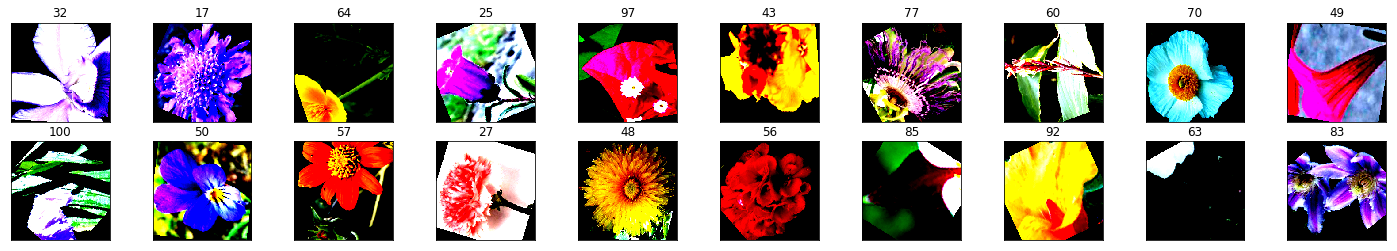

In [18]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.array(images[idx]).T)
    ax.set_title("{}".format(str(labels[idx].item())))

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [20]:
model = models.vgg19(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(nn.Linear(25088, 102))

model.classifier = classifier

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=.001, momentum=0.9)

model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [21]:
epochs = 1
valid_loss_min = np.Inf

for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            test_loss = 0
            accuracy = 0
            
            for images, labels in test_loader:
                images, labels = images.to('cuda'), labels.to('cuda')
                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            train_loss = running_loss/len(train_loader)
            test_loss = test_loss/len(test_loader)
            accuracy = accuracy/len(test_loader)
                
            print(f"Training Loss: {train_loss}",
                  f"Test Loss: {test_loss}",
                  f"Accuracy: {accuracy}")
            
            if test_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min, test_loss))
                
                torch.save(model.state_dict(), 'flower_classifier.pt')
                valid_loss_min = test_loss

            running_loss = 0
            model.train()

Training Loss: 0.017582404307830028 Test Loss: 4.724565819331578 Accuracy: 0.01904761961528233
Validation loss decreased (inf --> 4.724566).  Saving model ...
Training Loss: 0.017683184627211575 Test Loss: 4.724433272225516 Accuracy: 0.02380952441266605
Validation loss decreased (4.724566 --> 4.724433).  Saving model ...
Training Loss: 0.01791545148297544 Test Loss: 4.68719858442034 Accuracy: 0.0190476194024086
Validation loss decreased (4.724433 --> 4.687199).  Saving model ...
Training Loss: 0.01761811993497632 Test Loss: 4.6722684042794365 Accuracy: 0.028571429210049765
Validation loss decreased (4.687199 --> 4.672268).  Saving model ...
Training Loss: 0.0180774171710451 Test Loss: 4.64054160799299 Accuracy: 0.04047619125672749
Validation loss decreased (4.672268 --> 4.640542).  Saving model ...
Training Loss: 0.01683130369081602 Test Loss: 4.559144483293806 Accuracy: 0.04404762004102979
Validation loss decreased (4.640542 --> 4.559144).  Saving model ...
Training Loss: 0.0185624758

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
model.load_state_dict(torch.load('flower_classifier.pt'), strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

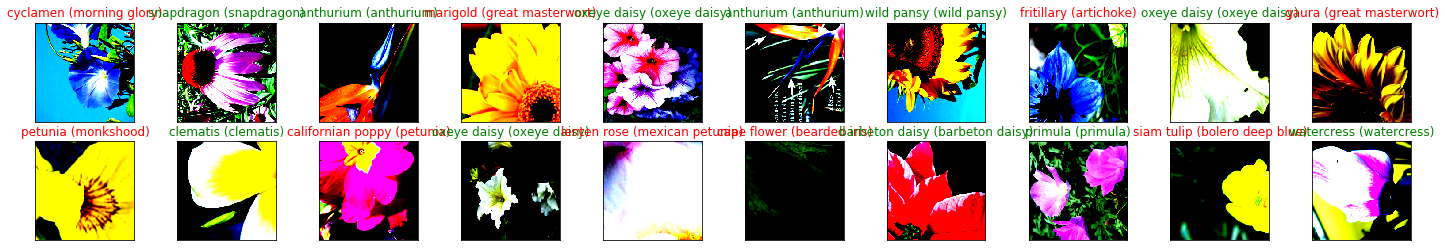

In [25]:
# TODO: Display an image along with the top 5 classes
images, labels = next(iter(test_loader))
model.cpu()
output = model(images)
_, preds =  torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.array(images[idx]).T)
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx].item())], cat_to_name[str(labels[idx].item())]),
                 color=("green" if preds[idx]==labels[idx] else "red"))